# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
* Idea

# Libraries

In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt

from data_processing import dataset
from data_processing import model_files
from models.network_elements import backbones, features
from losses import losses
from metrics import metrics
from utils import visualize, tools, learning_utils

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#np.set_printoptions(threshold=sys.maxsize)

# Load model configs
config_path = os.path.join(os.getcwd(), 'configs','edge')
model_config_path = os.path.join(config_path, 'model.yaml')
model_cfg = tools.config_loader(model_config_path)

# Initialize Dataset loader & parse arguments if given from command line
DataProcessing = dataset.DataProcessing(model_cfg["INPUT_SHAPE"], model_cfg["OUTPUT_SHAPE"], config_path)
LearningUtils = learning_utils.LearningUtil(DataProcessing.cfg['TRAIN']['BATCH_SIZE'], config_path)
tools.parser(model_cfg, DataProcessing.cfg)

# Get Path definitions where data is stored and the model should be stored
DataProcessing.path_definitions()
ModelFiles = model_files.ModelFiles()
ModelFiles.path_definitions(model_cfg["NAME"], DataProcessing.cfg["NAME"], make_dirs=True)
ModelFiles.clean_model_directories(LearningUtils.cfg["CALLBACKS"]["DEL_OLD_CKPT"], LearningUtils.cfg["CALLBACKS"]["DEL_OLD_TB"])

# SEED:
tf.random.set_seed(model_cfg['SEED'])

2022-11-08 19:08:42.986851: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load Dataset, Preprocess Images and Dataset

In [2]:
if LearningUtils.cfg['TRAIN_MODEL']:
    rng = tf.random.Generator.from_seed(123, alg='philox')

    train_ds, img_count_train = DataProcessing.load_dataset(DataProcessing.key.train, shuffle=True, prefetch=True, rng=rng)

test_ds, img_count_test = DataProcessing.load_dataset(DataProcessing.key.test, shuffle=False, prefetch=True)

2022-11-08 19:08:44.389093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 19:08:44.849347: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-08 19:08:44.849374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9665 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:22:00.0, compute capability: 8.6


The TEST DS contains 30 images.


In [4]:
if LearningUtils.cfg['TRAIN_MODEL']:
    for inp, out in train_ds.take(1):
        visualize.plot_edges(images=inp['in_img'], labels=out['out_edge'], 
                             batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                             num_classes=DataProcessing.num_classes['edge'])

# Model

In [5]:
if model_cfg['LOSS']['SIGMOID']:
    loss = lambda y_true, y_pred: losses.weighted_multi_label_sigmoid_loss(y_true, y_pred, beta_lower=1.0 - model_cfg['LOSS']['BETA_UPPER'],
                                                                           beta_upper=model_cfg['LOSS']['BETA_UPPER'],
                                                                           class_weighted=model_cfg['LOSS']['CLASS_WEIGHTED'])
elif model_cfg['LOSS']['FOCAL']:
    loss = lambda y_true, y_pred: losses.focal_loss_edges(y_true, y_pred, gamma=model_cfg['LOSS']['GAMMA'], weighted_beta=model_cfg['LOSS']['BETA_WEIGHTED'], beta_lower=1.0 - model_cfg['LOSS']['BETA_UPPER'], beta_upper=model_cfg['LOSS']['BETA_UPPER'])
else:
    raise ValueError("either FocalLoss or WeightedMultiLabelSigmoidLoss must be True")


In [6]:
if LearningUtils.cfg['TRAIN_MODEL']:
    output_dims = model_cfg["OUTPUT_SHAPE"]

    # BACKBONE
    backbone, output_names = backbones.get_backbone(name=model_cfg["BACKBONE"]["NAME"],
                                                    weights=model_cfg["BACKBONE"]["WEIGHTS"],
                                                    height=model_cfg["INPUT_SHAPE"][0],
                                                    width=model_cfg["INPUT_SHAPE"][1],
                                                    alpha=model_cfg["BACKBONE"]["ALPHA"],
                                                    output_layer=model_cfg["BACKBONE"]["OUTPUT_IDS"],
                                                    trainable_idx=model_cfg["BACKBONE"]["TRAIN_IDX"])

    # DASPP
    daspp = features.DASPP_dilation(backbone.output[-1])

    # Decoder
    decoded = features.decoder(daspp, backbone.output[-1], output_dims=output_dims, NUM_CLASSES=DataProcessing.num_classes['edge'],
                               num_side_filters=6)

    # SIDE FEATURES
    # TODO: Upsampling: Nearest NEIGHBOUR ?
    upsample_side_1 = features.side_feature_SGED(backbone.output[0], output_dims=output_dims,
                                                 num_classes=DataProcessing.num_classes['edge'], method="bilinear", name="side1")
    upsample_side_2 = features.side_feature_SGED(backbone.output[1], output_dims=output_dims,
                                                 num_classes=DataProcessing.num_classes['edge'], method="bilinear", name="side2")
    # upsample_side_3 = features.side_feature_SGED(backbone.output[2], output_dims=output_dims ,interpolation="bilinear", name="side3")

    # TODO: adaptive weight fusion ?
    # CONCATENATE
    side_outputs = [upsample_side_1, upsample_side_2, decoded]
    # concat = features.shared_concatenation(side_outputs,NUM_CLASSES)
    # output = features.fused_classification(concat,NUM_CLASSES,name="output")
    output = features.shared_concatenation_fused_classification(side_outputs, DataProcessing.num_classes['edge'],
                                                                name="out_edge")
    model = tf.keras.Model(inputs=backbone.input, outputs=output)

    # model.layers[-1]._name = "output"
    model.summary()


# Compile and Train Model

In [7]:
if LearningUtils.cfg['TRAIN_MODEL']:
    lr = LearningUtils.get_lr(img_count_train)
    #lr = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
                  loss={'out_edge': loss},
                  metrics={'out_edge': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                           metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

    history = model.fit(train_ds, epochs=LearningUtils.cfg["EPOCHS"], validation_data=test_ds, callbacks=LearningUtils.get_callbacks(img_count_train, ModelFiles.paths))

print(ModelFiles.get_model_path_max_f1())
custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges, "F1Edges": metrics.F1Edges, "<lambda>": loss}
model = tf.keras.models.load_model(ModelFiles.get_model_path_max_f1(), custom_objects=custom_objects)

/home/david/SemesterProject/Models/test/TEST/CKPT/ckpt-loss=1305.77-epoch=120.00-f1=0.9056


# Plot Results

In [8]:
if LearningUtils.cfg['TRAIN_MODEL']:
    plot_losses = ["loss", "loss"]
    plot_metrics = ["accuracy_edges", "f1", "recall", "precision"]

    path = os.path.join(ModelFiles.paths["FIGURES"], "training.svg")

    visualize.plot_training_results(res=history.history, losses=plot_losses, metrics=plot_metrics,
                                    save=model_cfg["SAVE"], path=path)

2022-11-08 19:09:39.709321: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 2s 2s/step


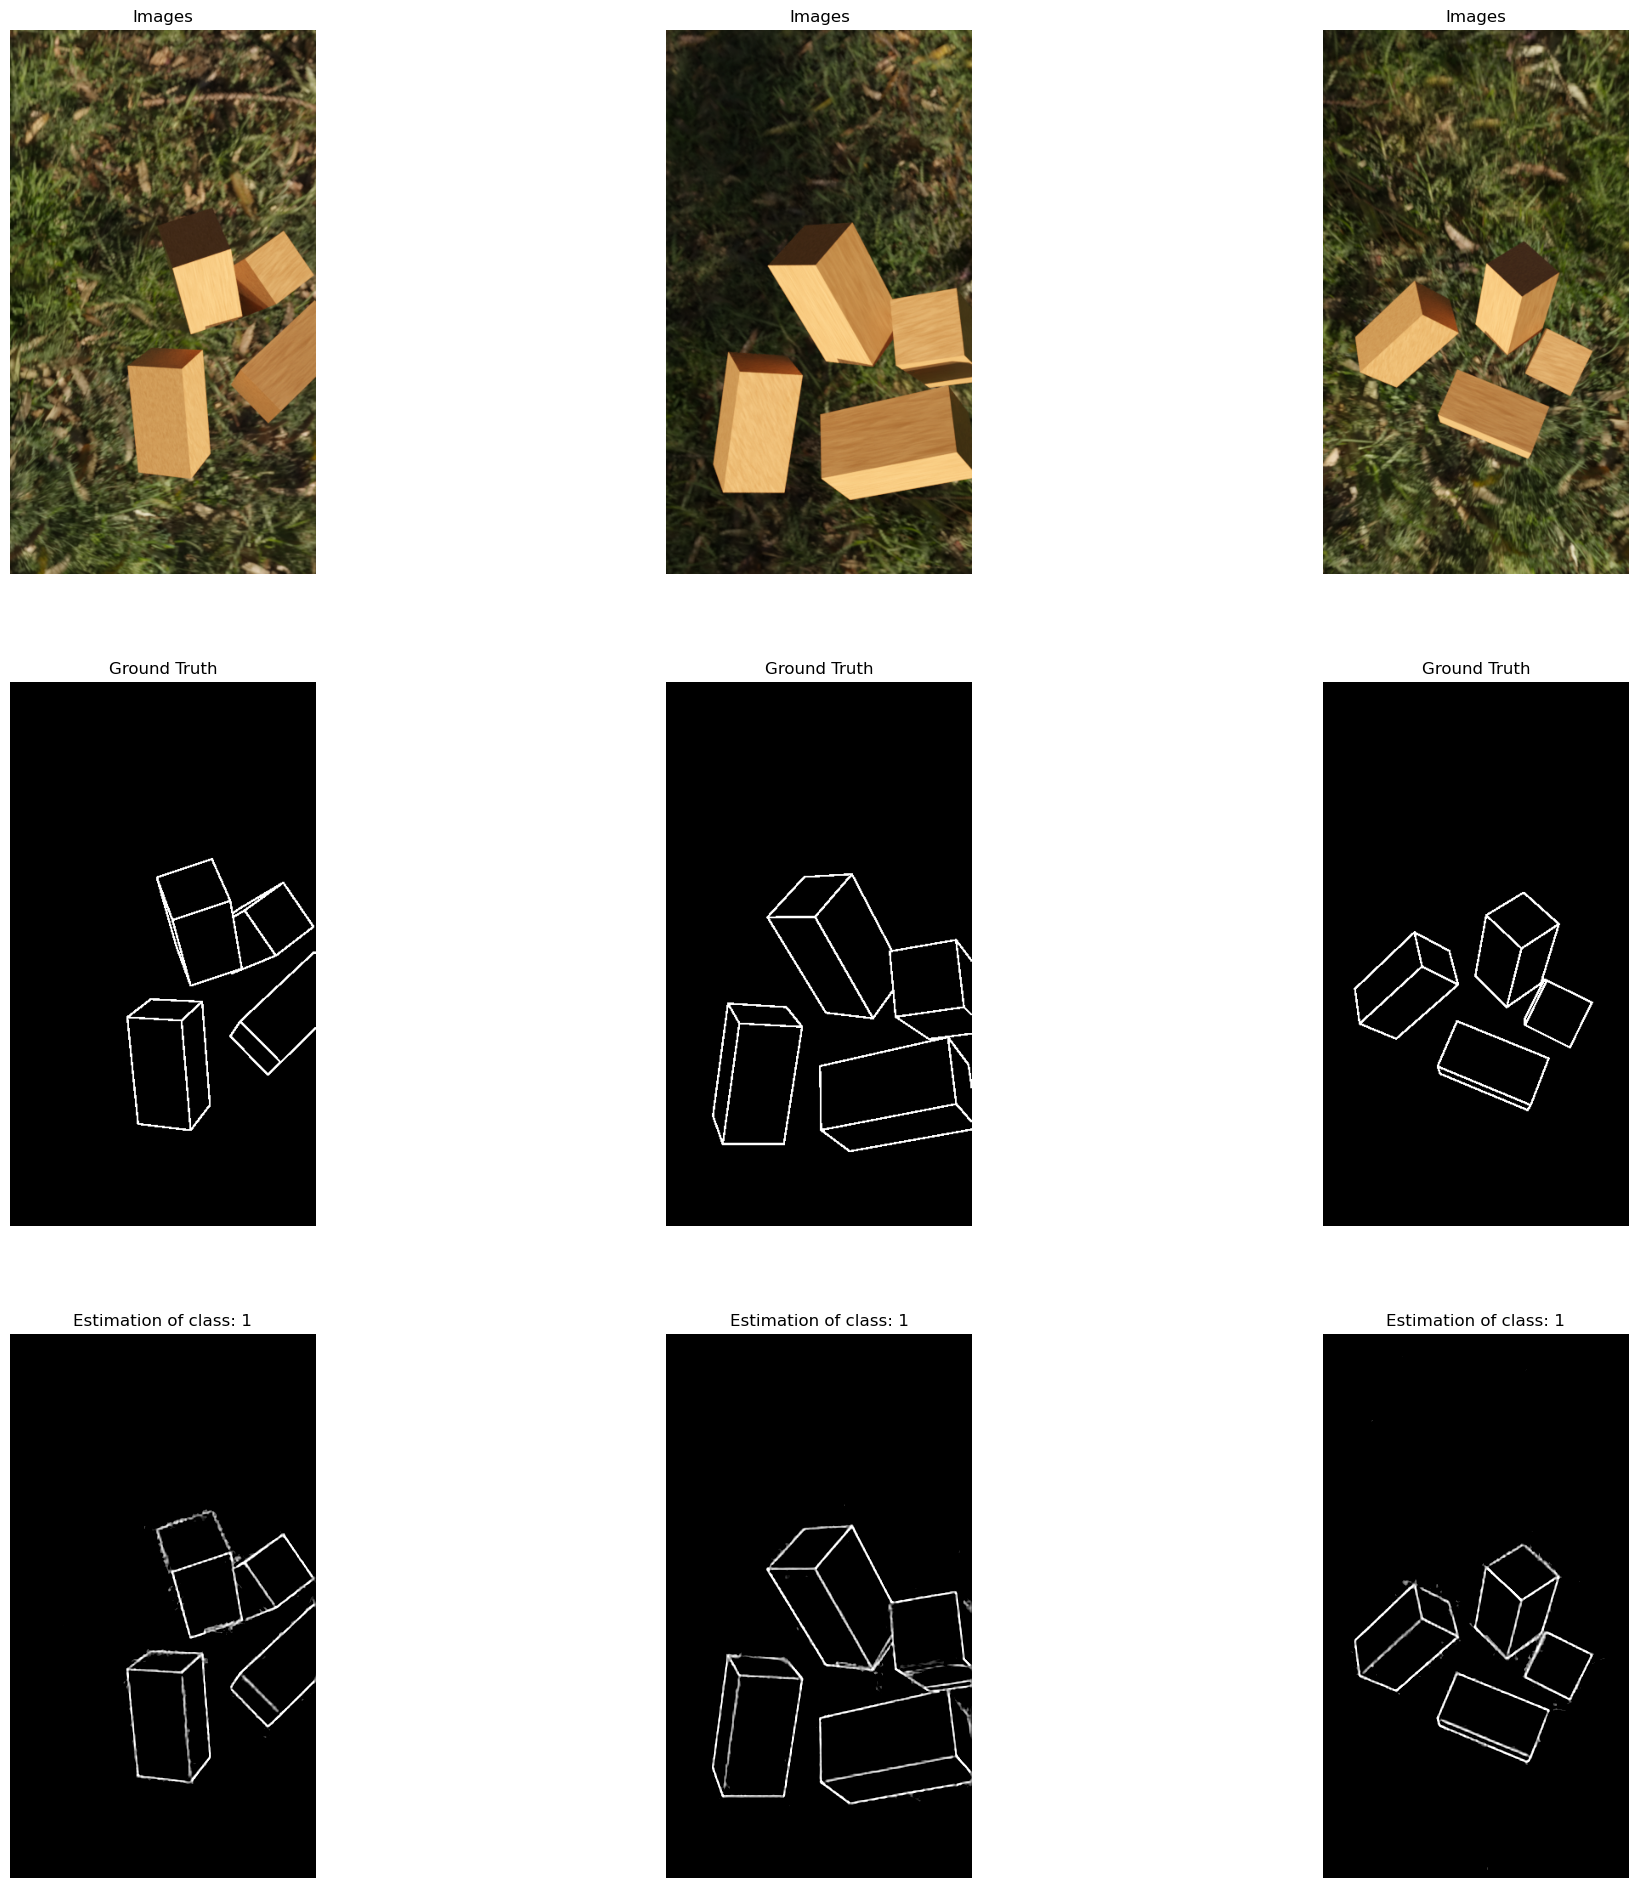

2022-11-08 19:09:41.664814: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    visualize.plot_edges(images=inp['in_img'], labels=out['out_edge'],
                         predictions=pred,
                         batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                         num_classes=DataProcessing.num_classes['edge'])

In [11]:
### Maximum F1 Score:
# TODO: FAILS right now: fix
# if not TRAIN_MODEL:
#     step_width = 0.05
#     threshold_range = [0.05, 0.95]
#     threshold_array = np.arange(threshold_range[0], threshold_range[1] + step_width, step_width)
#     threshold_array = np.array([0.025, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.975])
#
#     path_metrics_evaluation_plot = os.path.join(ModelFiles.paths["FIGURES"], "threshold_metrics_evaluation_test_ds.svg")
#     threshold_f1_max = visualize.plot_threshold_metrics_evaluation_class(model=model, ds=test_ds,
#                                                                          num_classes=DataProcessing.num_classes['EDGE'],
#                                                                          threshold_array=threshold_array,
#                                                                          threshold_edge_width=0, save=model_cfg["SAVE"],
#                                                                          path=path_metrics_evaluation_plot)

# Fine Tuning

# Evaluate on Test DS of Real Images

## Metrics Evaluation

## Visual Results

# Save Model

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics={
    'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
               metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

if model_cfg["SAVE"]:
    model.save(ModelFiles.paths["MODEL"])

    custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges, "F1Edges": metrics.F1Edges, "<lambda>": loss}

    model = tf.keras.models.load_model(ModelFiles.paths["MODEL"], custom_objects=custom_objects)